In [2]:
from dataloader.dataloader import CellNucleiDataset

In [35]:
from __future__ import annotations
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, Resize

In [9]:
CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))

dataset = CellNucleiDataset.create(
        images_path=os.path.join(CURRENT_DIR, '..', 'dataset', 'rawimages'),
        groundtruth_path=os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth'),
        target_size=(1024, 1360),  # biggest image in the dataset
        transform=ToTensor(),
)

In [11]:
x, y = next(iter(dataset))

x.shape

torch.Size([1, 1024, 1360])

## Plot X and y from the dataset

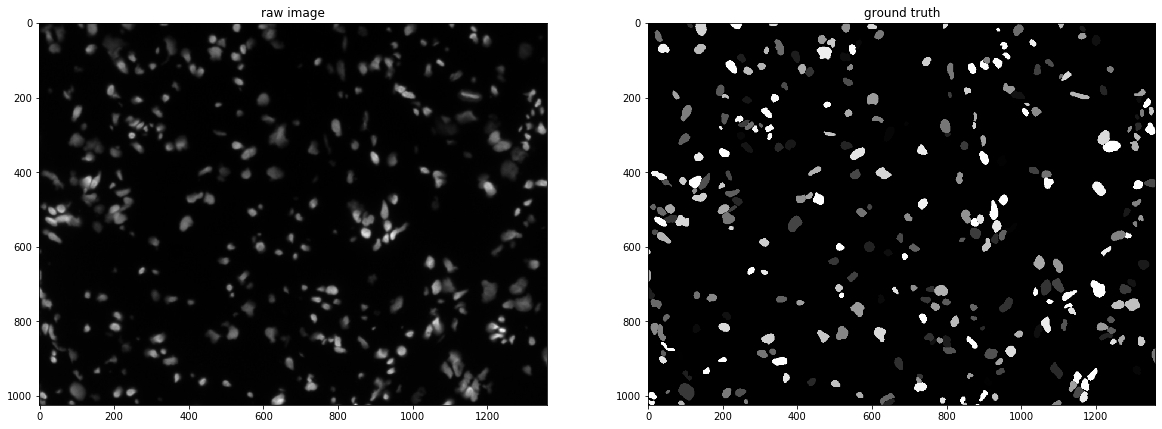

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y)[0], cmap="gray")
axes[1].set_title("ground truth")

plt.show()

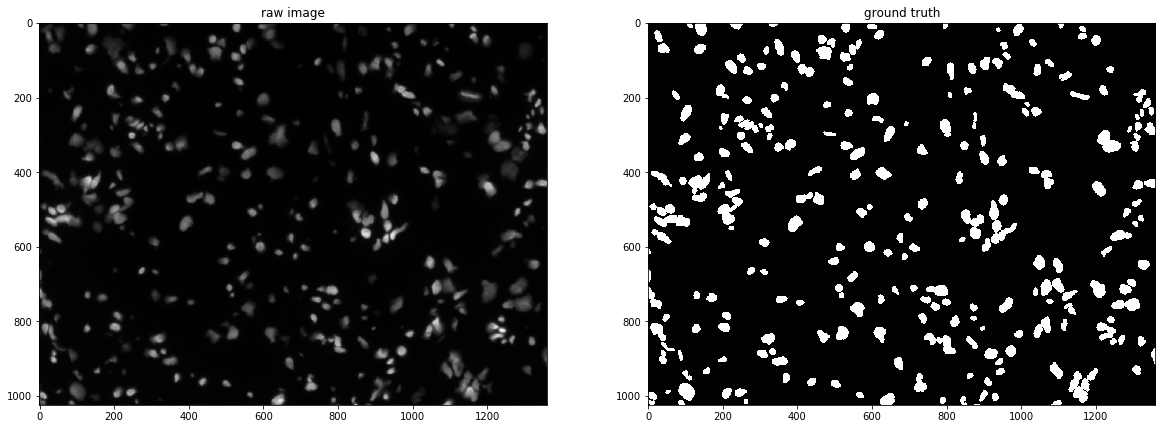

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y)[0] > 0, cmap="gray")
axes[1].set_title("ground truth")

plt.show()

## Visualize clusters with numbers

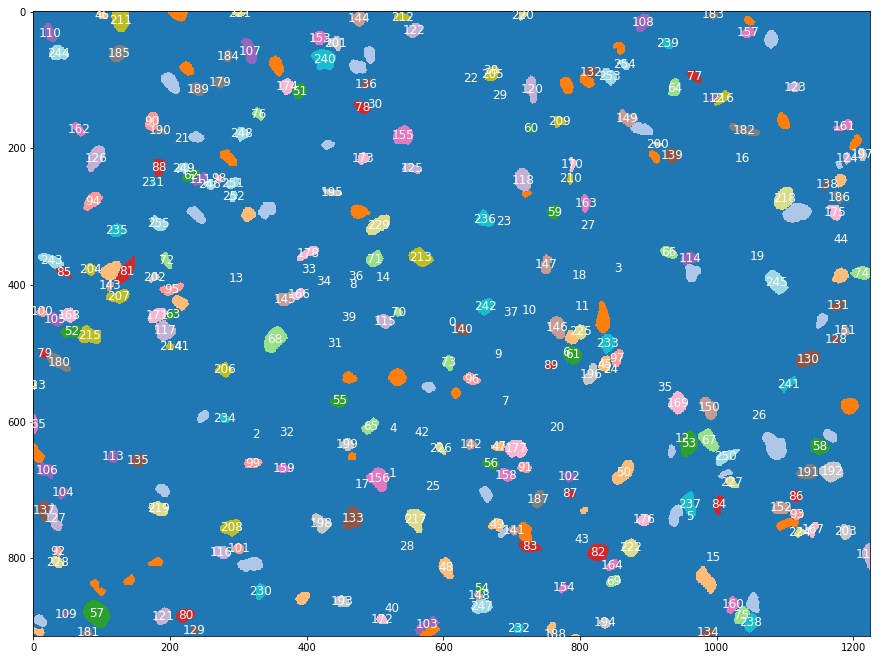

In [52]:
# Load the image as a numpy array
y = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

# Get the unique cluster labels
clusters = np.unique(y)

# Assign a color to each cluster label
colors = cmap(range(len(clusters)))

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y, cmap=cmap, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')


plt.show()

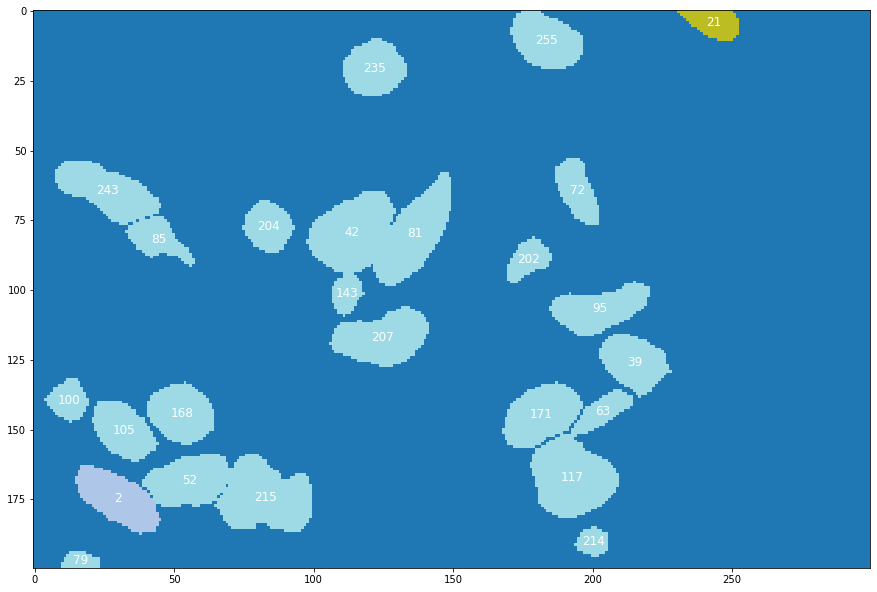

In [58]:
# Load the image as a numpy array
y = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

y = y[300:500, 0:300]
# Get the unique cluster labels
clusters = np.unique(y)

# Assign a color to each cluster label
colors = cmap(range(len(clusters)))

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y, cmap=cmap, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    if cluster == 0:
        continue
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')

plt.show()